Iteración: 1
Tamaño del conjunto de entrenamiento: 2576
Tamaño del conjunto para la predicción: 515
Fechas de inicio y fin del conjunto de entrenamiento: 1997-05-16 00:00:00 - 2007-08-20 00:00:00
Fechas de inicio y fin del conjunto para la predicción: 2007-08-21 00:00:00 - 2009-09-03 00:00:00
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


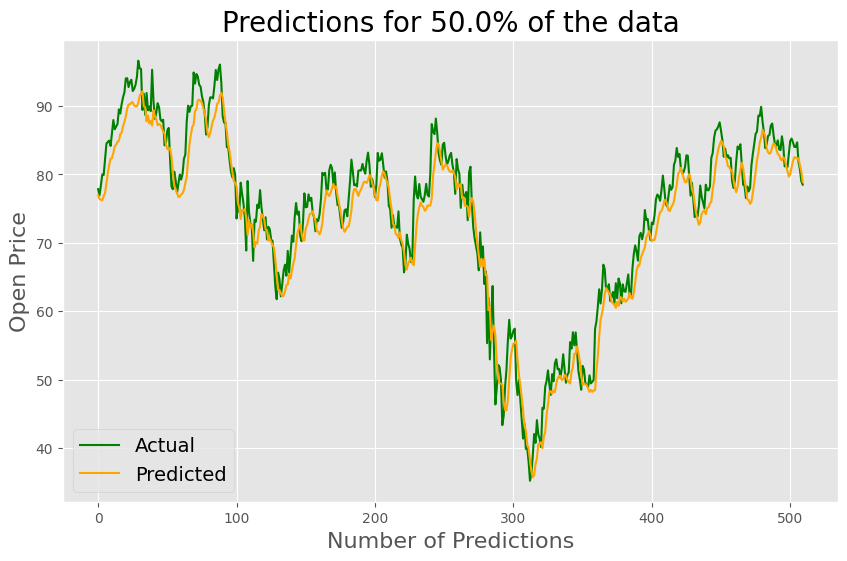

Iteración: 2
Tamaño del conjunto de entrenamiento: 3091
Tamaño del conjunto para la predicción: 516
Fechas de inicio y fin del conjunto de entrenamiento: 1997-05-16 00:00:00 - 2009-09-03 00:00:00
Fechas de inicio y fin del conjunto para la predicción: 2009-09-04 00:00:00 - 2011-09-21 00:00:00
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


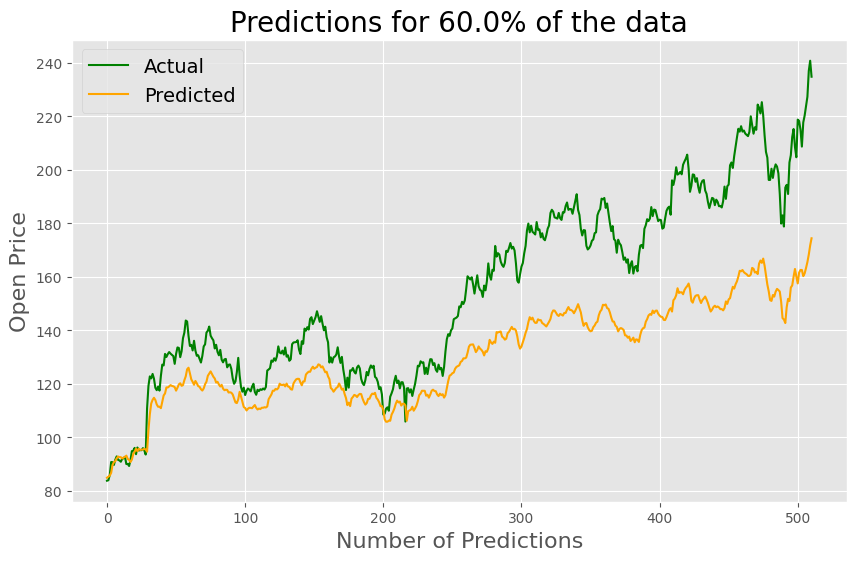

Iteración: 3
Tamaño del conjunto de entrenamiento: 3607
Tamaño del conjunto para la predicción: 515
Fechas de inicio y fin del conjunto de entrenamiento: 1997-05-16 00:00:00 - 2011-09-21 00:00:00
Fechas de inicio y fin del conjunto para la predicción: 2011-09-22 00:00:00 - 2013-10-09 00:00:00
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


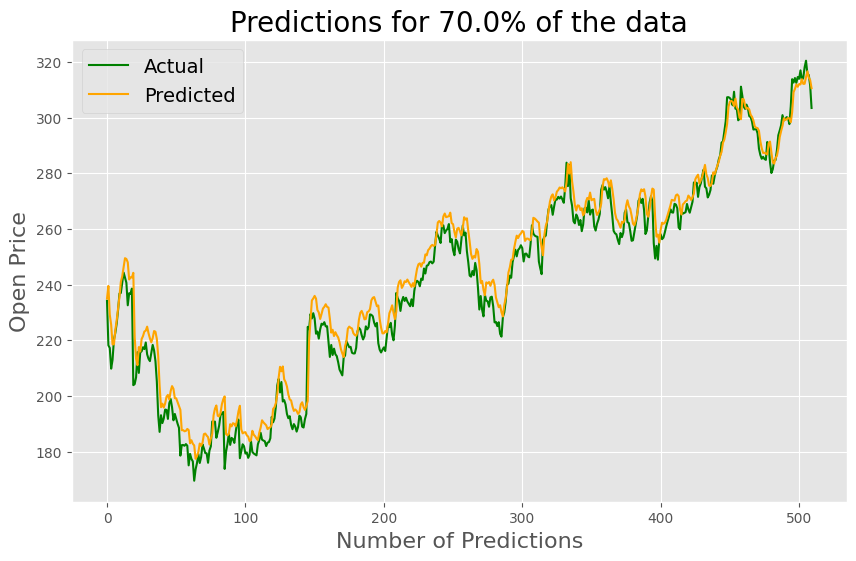

Iteración: 4
Tamaño del conjunto de entrenamiento: 4122
Tamaño del conjunto para la predicción: 515
Fechas de inicio y fin del conjunto de entrenamiento: 1997-05-16 00:00:00 - 2013-10-09 00:00:00
Fechas de inicio y fin del conjunto para la predicción: 2013-10-10 00:00:00 - 2015-10-26 00:00:00
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


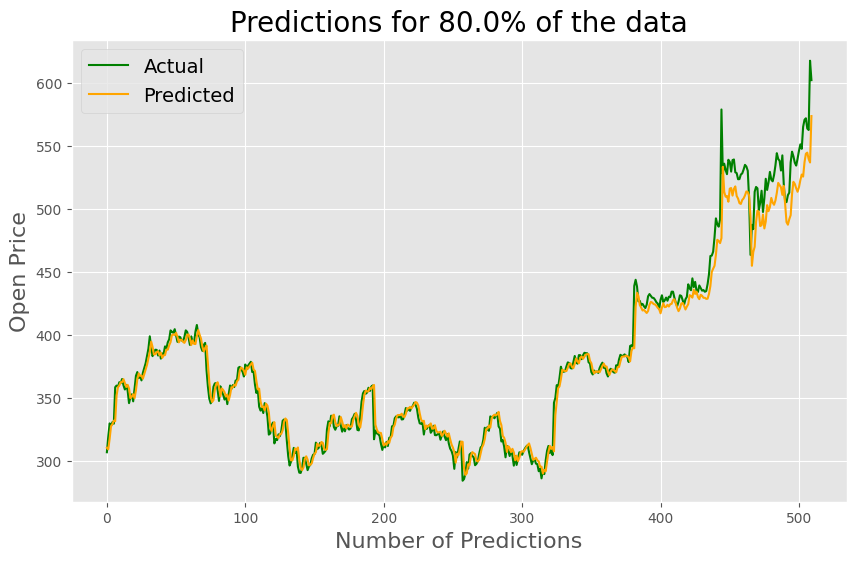

Iteración: 5
Tamaño del conjunto de entrenamiento: 4637
Tamaño del conjunto para la predicción: 516
Fechas de inicio y fin del conjunto de entrenamiento: 1997-05-16 00:00:00 - 2015-10-26 00:00:00
Fechas de inicio y fin del conjunto para la predicción: 2015-10-27 00:00:00 - 2017-11-10 00:00:00
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


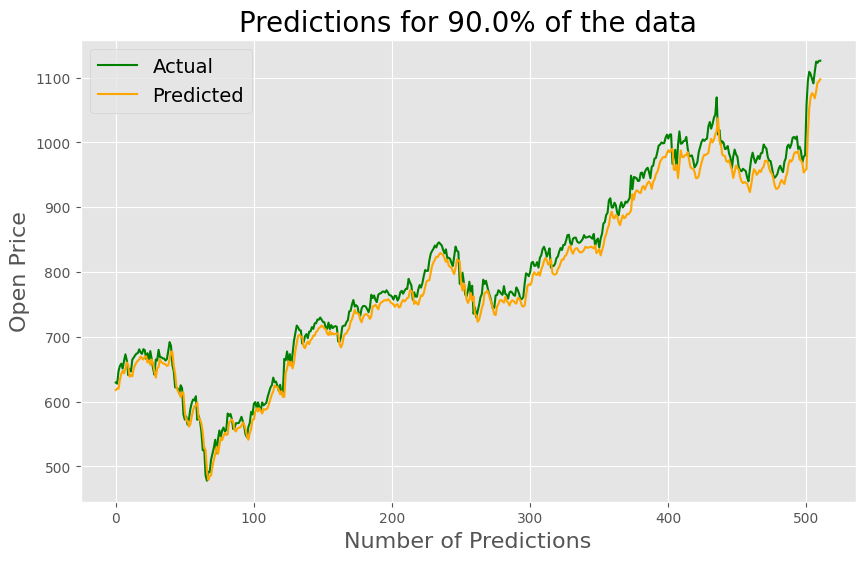

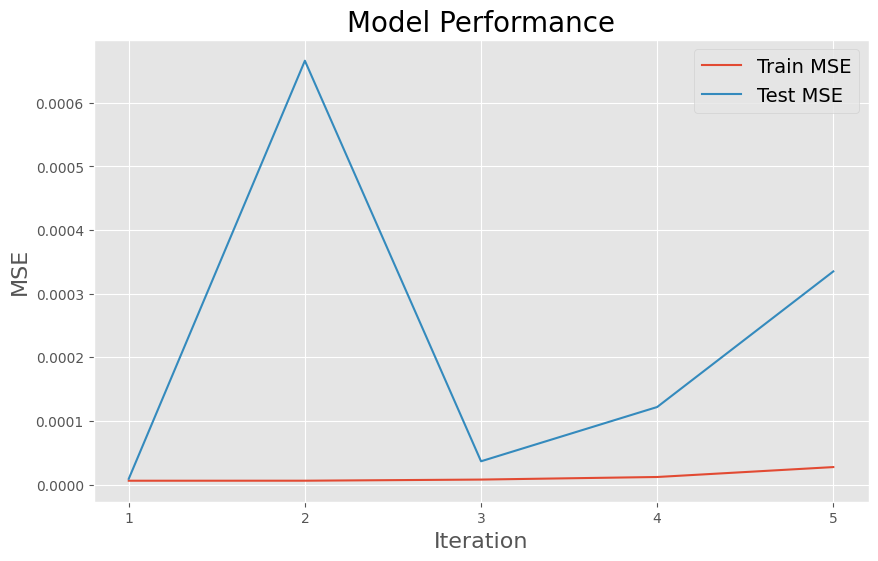

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers
plt.style.use('ggplot')
# Descargar los datos
df = pd.read_csv('amzn.us.txt')
df = df[['Date', 'Open']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Normalizar los datos
scaler = MinMaxScaler()
df['Open'] = scaler.fit_transform(df[['Open']])

# Función para dividir los datos de entrenamiento y testeo
def train_test_split(data, train_size):
    train_index = int(len(data) * train_size)
    train_data, test_data = data[:train_index], data[train_index:]
    return train_data, test_data

# Función para crear secuencias de datos para el modelo
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Función para crear el modelo Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, attention_axes=1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout, attention_axes=attention_axes)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0):
    n_timesteps, n_features, n_outputs = seq_length, 1, 1 
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs 
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs, activation='relu')(x)
    return tf.keras.Model(inputs, outputs)

# Parámetros
seq_length = 5  # longitud de la secuencia de entrada
train_size_initial = 0.5  # tamaño inicial del conjunto de entrenamiento
train_size_increment = 0.1  # incremento en el tamaño del conjunto de entrenamiento

# Listas para almacenar las métricas de rendimiento
mse_train = []
mse_test = []

model = build_transformer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10)
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=["mae", 'mape'])

# El bucle debe ir de 0 a 5 para incluir el 50%, 60%, ..., 100% de los datos
for i in range(5):
    train_size = train_size_initial + i * train_size_increment
    
    if train_size > 1.0:
        break

    print("Iteración:", i+1)
    
    # Tamaño del conjunto de entrenamiento y conjunto para la predicción
    train_index_end = int(train_size * len(df))
    if train_index_end > len(df):
        train_index_end = len(df)

    test_index_start = train_index_end
    test_index_end = int((train_size + train_size_increment) * len(df))
    if test_index_end > len(df):
        test_index_end = len(df)

    train_start_date = df.index[0]
    train_end_date = df.index[train_index_end - 1]
    test_start_date = df.index[test_index_start] if test_index_start < len(df) else df.index[-1]
    test_end_date = df.index[test_index_end - 1] if test_index_end <= len(df) else df.index[-1]

    print("Tamaño del conjunto de entrenamiento:", train_index_end)
    print("Tamaño del conjunto para la predicción:", test_index_end - test_index_start)
    print("Fechas de inicio y fin del conjunto de entrenamiento:", train_start_date, "-", train_end_date)
    print("Fechas de inicio y fin del conjunto para la predicción:", test_start_date, "-", test_end_date)

 
    
    # Entrenar el modelo
    train_data, _ = train_test_split(df['Open'].values, train_size)
    X_train, y_train = create_sequences(train_data, seq_length)
    if len(X_train) == 0:  # Evitar el entrenamiento si no hay suficientes datos
        print("No hay suficientes datos para entrenar en esta iteración.")
        continue
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Calcular el error cuadrático medio en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    
    # Realizar la predicción en el siguiente conjunto de prueba
    test_data = df['Open'].values[test_index_start:test_index_end]
    X_test, y_test = create_sequences(test_data, seq_length)
    if len(X_test) == 0:  # Evitar la predicción si no hay suficientes datos
        print("No hay suficientes datos para predecir en esta iteración.")
        continue
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_pred = model.predict(X_test)
    mse_test.append(mean_squared_error(y_test, y_pred))
    
    # Plotear resultados para la predicción actual
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', color = "green")
    plt.plot(range(len(y_pred)), scaler.inverse_transform(y_pred), label='Predicted', color = "orange")
    plt.title(f'Predictions for {(train_size + train_size_increment - 0.1):.1%} of the data', fontsize=20)
    plt.xlabel('Number of Predictions', fontsize=16)
    plt.ylabel('Open Price', fontsize=16)
    plt.legend(fontsize=14)
    plt.savefig(f'TRANS_plot_{i}.png') 
    plt.show()

# Graficar las métricas de rendimiento
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_train) + 1), mse_train, label='Train MSE')
plt.plot(range(1, len(mse_test) + 1), mse_test, label='Test MSE')
plt.title('Model Performance', fontsize=20)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.xticks(range(1, len(mse_train) + 1))
plt.legend(fontsize=14)
plt.savefig('TRANS.png')
plt.show()


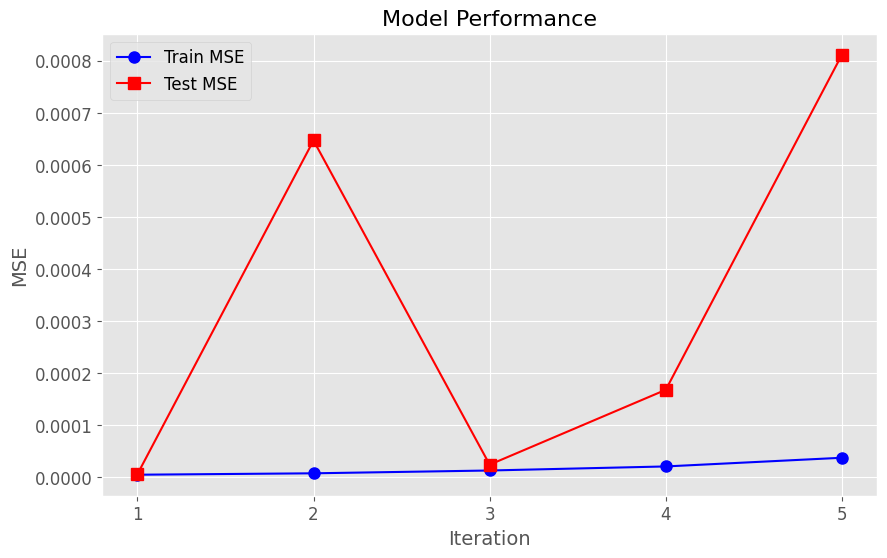

In [6]:
import matplotlib.pyplot as plt

# Establecer estilo
plt.style.use('ggplot')

# Graficar las métricas de rendimiento
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_train) + 1), mse_train, 'o-', label='Train MSE', markersize=8, color='blue')
plt.plot(range(1, len(mse_test) + 1), mse_test, 's-', label='Test MSE', markersize=8, color='red')

plt.title('Model Performance', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.xticks(range(1, len(mse_train) + 1), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Guardar el gráfico
plt.savefig('TRANS.png', bbox_inches='tight')
plt.show()

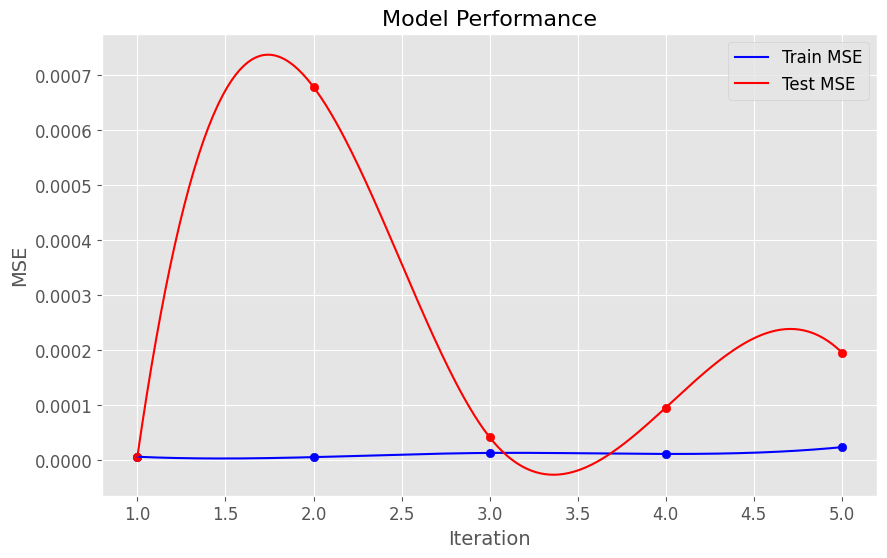

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Establecer estilo de gráfico y ajustar algunas configuraciones
plt.style.use('ggplot')

# Suavizar los datos con interpolación spline
x_new = np.linspace(1, len(mse_train), 300)  # Crear una nueva serie de puntos más densos
spl_train = make_interp_spline(range(1, len(mse_train) + 1), mse_train)
spl_test = make_interp_spline(range(1, len(mse_test) + 1), mse_test)
mse_train_smooth = spl_train(x_new)
mse_test_smooth = spl_test(x_new)

# Graficar las métricas de rendimiento con líneas suavizadas y puntos
plt.figure(figsize=(10, 6))
plt.plot(x_new, mse_train_smooth, label='Train MSE', color='blue', linestyle='-')
plt.scatter(range(1, len(mse_train) + 1), mse_train, color='blue', marker='o')
plt.plot(x_new, mse_test_smooth, label='Test MSE', color='red', linestyle='-')
plt.scatter(range(1, len(mse_test) + 1), mse_test, color='red', marker='o')

plt.title('Model Performance', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Guardar el gráfico
plt.savefig('TRANS.png', bbox_inches='tight')
plt.show()
